# SPICY Tutorial 2

In this tutorial we use SPICY for the constrained regression of a solenoidal velocity field in 2D. We perform the regression in two ways: 

1. Free regression of two scalar fields, using one SPICY object per component. 

2. Penalized regression with one vector field, using one SPICY object with penalties on the div free condition.

We start by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

from spicy_class_m import spicy 

# This is for plot customization
fontsize = 12
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

#### Test Case Definition

We consider the domain $(x,y) = [-0.5,0.5]\times[-0.5,0.5]$ and the velocity field produced by an Oseen vortex.

In terms of radial an tangential components respectively, this means $u_r = 0$ and $u_\theta = \Gamma/2 \pi r \left( 1- e ^{-r^2/c_\theta}\right)$.

Here, $c_\theta = r_c^2 / \gamma$, with $r_c = 0.1$ the radial distance of maximum velocity, $\gamma = 1.25643$ and $\Gamma = 10$ the dimensionless circulation.

We assume that the flow has been sampled over $n_p=1000$ scattered points and a random error with 0.4 maximum intensity is present in the measurement


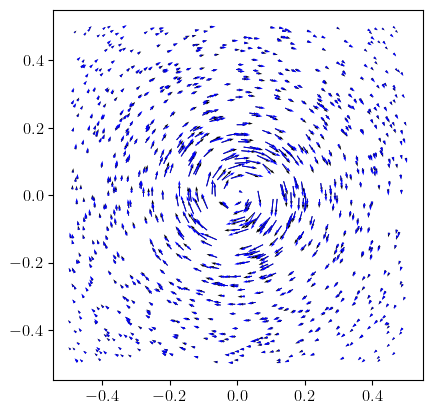

In [12]:
# Fix the random seed to ensure reproducibility
np.random.seed(42)

# Number of particles
n_p = 1000

# Define the domain boundaries and flow properties
x1_hat, x2_hat = -0.5, 0.5 # m, m
y1_hat, y2_hat = -0.5, 0.5 # m, m
rho = 1 # kg/m^3
mu = 0 # Pa s

# Generate the random points
X = np.random.random(n_p)*(x2_hat - x1_hat) + x1_hat
Y = np.random.random(n_p)*(y2_hat - y1_hat) + y1_hat

# Compute the radius and angle in the 2D domain
r = np.sqrt(X**2 + Y**2); theta = np.arctan2(Y, X)

# Hyperparameters of the vortex
Gamma = 10; r_c = 0.1; gamma = 1.256431; c_theta = r_c**2/gamma

# Compute the velocity field
u_theta = Gamma / (2*np.pi*r) * (1 - np.exp(-r**2 / (r_c**2 / gamma)))
U = np.sin(theta) * u_theta
V = -np.cos(theta) * u_theta 

# Add 0.4 max noise to it
q = 0.4
U_noise = U * (1 + q*np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q*np.random.uniform(-1, 1, size = V.shape))

# Plot the sampled field: black arrows for the true fields, blu arrows for the noisy one
plt.quiver(X,Y,U,V)
plt.quiver(X,Y,U_noise,V_noise,color='blue')
plt.gca().set_aspect('equal')


## Approach 1: Unconstrained regression(s) of scalar fields

We proceed with the approach one: one regression for each component and no constraints!


In [5]:
# We use one regression for each component.
SP_U = spicy([U_noise], [X,Y], basis='c4') # initialize object
SP_U.clustering([6,20], r_mM=[0.05,0.6], eps_l=0.88) # cluster
SP_U.scalar_constraints() #add no constraints!
#SP_U.plot_RBFs() # plot the result of the clustering

SP_U.Assembly_Regression() # Assembly the linear system
SP_U.Solve(K_cond=1e8) # Solve the regression with regularization active when condition number exceed 1e8)
U_c = SP_U.Get_Sol([X,Y]) # get solution on (X,Y)
# Evaluate the error wrt to the noise free data
error = np.linalg.norm(U_c - U) / np.linalg.norm(U)
print('l2 relative error in u component: {0:.3f}%'.format(error*100))


Clustering level 0 completed
Clustering level 1 completed
0 Dirichlet conditions assigned
0 Neumann conditions assigned
Solving without constriaints
Matrix A regularized
l2 relative error in u component: 5.875%


We now repeat the same for the regression of the velocty data. Note that we do not want to re-do the clustering so we just clone the SPICY object, replace the target data and continue from there onward. Then, we plot the results

Solving without constriaints
Matrix A regularized
l2 relative error in v component: 5.586%


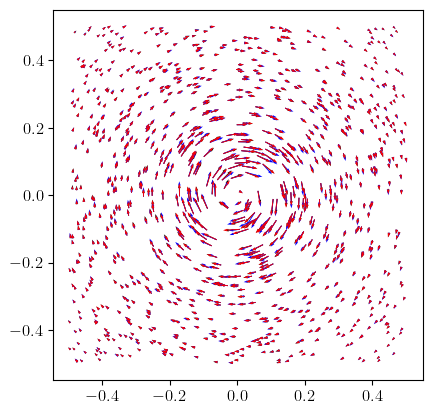

In [10]:
SP_V=SP_U # clone the SPICY object
SP_V.u = V_noise # Chang only the target data (for scalar, this is u) 
SP_V.Assembly_Regression() # Assembly the linear system
SP_V.Solve(K_cond=1e8) # Solve the regression with regularization active when condition number exceed 1e8)
V_c = SP_V.Get_Sol([X,Y]) # get solution on (X,Y)
# Evaluate the error wrt to the noise free data
error = np.linalg.norm(V_c - V) / np.linalg.norm(V)
print('l2 relative error in v component: {0:.3f}%'.format(error*100))

# Then plot the results:
plt.figure(2)
plt.quiver(X,Y,U,V)
plt.quiver(X,Y,U_noise,V_noise,color='blue')
plt.quiver(X,Y,U_c,V_c,color='red')
plt.gca().set_aspect('equal')

We obained an error of the order of 7.5 % with respect to the clean signal. Judging from the quiver plot, it is not too bad.

## Approach 2: Unconstrained regression(s) of a vector field

We use one SPICY object and proceed with the regression of a vector field. We include penalties on the divergence free condition. We create the object and clone the cluster data. Then proceed from there onward.

In [11]:
SP_vec = spicy([U_noise,V_noise], [X,Y], basis='c4') # create SPICY object
# clone the cluster data:
SP_vec.r_mM=SP_V.r_mM; SP_vec.eps_l=SP_V.eps_l;     
SP_vec.X_C=SP_V.X_C; SP_vec.Y_C=SP_V.Y_C;     
SP_vec.c_k=SP_V.c_k; SP_vec.d_k=SP_V.d_k;     
# Proceed as usual: constraints + assembly regression + solve 
SP_vec.vector_constraints() #add no constraints!
SP_vec.Assembly_Regression(alpha_div=1) # assembly with a penalty of 1 on div
SP_vec.Solve(K_cond=1e8) # Solve as usual
# Get the results on the same grid:
U_c,V_c=SP_vec.Get_Sol([X,Y])
     
error = np.linalg.norm(U_c - U) / np.linalg.norm(U)
print('l2 relative error in u component: {0:.3f}%'.format(error*100))
error = np.linalg.norm(V_c - V) / np.linalg.norm(V)
print('l2 relative error in v component: {0:.3f}%'.format(error*100))
   

0 D conditions assigned
0 N conditions assigned
0 Div conditions assigned
Solving without constriaints
Matrix A regularized
l2 relative error in u component: 5.156%
l2 relative error in v component: 4.876%


The penalty helps reducing slightly the error ! 